# 4. Baseline_Model and Visualization

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [36]:
df = pd.read_csv("D:/Kevin Osioma/data/raw_listings_data.csv")
df_model = df.copy()

# More Cleaning

In [37]:
# After loading clean_listings.csv, add this:

print(f"Before additional cleaning: {len(df_model)} rows")

# 1. Remove extreme luxury properties
df_model = df_model[df_model['price_kes'] <= 100_000_000]
print(f"After removing >100M: {len(df_model)} rows")

# 2. Remove price_per_sqft outliers
df_model = df_model[df_model['price_per_sqft'] <= 50_000]
print(f"After removing price/sqft outliers: {len(df_model)} rows")

# 3. Remove very cheap properties (likely errors)
df_model = df_model[df_model['price_kes'] >= 5_000_000]
print(f"After removing <5M: {len(df_model)} rows")

print(f"\nFinal dataset: {len(df_model)} rows")

Before additional cleaning: 759 rows
After removing >100M: 685 rows
After removing price/sqft outliers: 657 rows
After removing <5M: 637 rows

Final dataset: 637 rows


# Enncoding Property_Type and Location

In [38]:
# Encode Location
le_location = LabelEncoder()
df_model['location_encoded'] = le_location.fit_transform(df_model['location'])


print("\nLocation Encoding (first 5):")
location_mapping = dict(zip(le_location.classes_, le_location.transform(le_location.classes_)))
for i, (loc, code) in enumerate(location_mapping.items()):
    if i < 5:
        print(f"  {loc} → {code}")


Location Encoding (first 5):
  Donholm → 0
  Garden Estate → 1
  Kahawa Sukari → 2
  Karen → 3
  Kiambu Road → 4


In [39]:
#Encode Property Type
le_property = LabelEncoder()
df_model['property_type_encoded'] = le_property.fit_transform(df_model['property_type'])

print("\nProperty Type Encoding:")
property_mapping = dict(zip(le_property.classes_, le_property.transform(le_property.classes_)))
for ptype, code in property_mapping.items():
    print(f"  {ptype} → {code}")


Property Type Encoding:
  Apartment → 0
  House → 1
  Townhouse → 2


# Feature Selecting

In [40]:
# Define features (X) and target (y)
feature_columns = [
    'bedrooms',
    'bathrooms', 
    'size_sqft',
    'location_encoded',
    'property_type_encoded',
    'amenity_score'
]

X = df_model[feature_columns]
y = df_model['price_kes']

In [41]:
print(f"\nFeatures selected: {feature_columns}")
print(f"   X shape: {X.shape}")
print(f"   y shape: {y.shape}")

# Final check
print("\nFinal check:")
print(f"  Missing values in X: {X.isnull().sum().sum()}")
print(f"  Missing values in y: {y.isnull().sum()}")


Features selected: ['bedrooms', 'bathrooms', 'size_sqft', 'location_encoded', 'property_type_encoded', 'amenity_score']
   X shape: (637, 6)
   y shape: (637,)

Final check:
  Missing values in X: 0
  Missing values in y: 0


# Training & Testing the Split

In [42]:
# Split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [43]:
print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")


Training set: 509 samples
Test set: 128 samples


# Building a Linear Regression Model

In [44]:
# Create and train model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [45]:
print("\n Model trained successfully!")
print(f"   Trained on {len(X_train)} samples")


 Model trained successfully!
   Trained on 509 samples


# Prediction

In [46]:
# Predict on test set
y_pred = model.predict(X_test)

In [47]:
print("\nPredictions made on test set")
print(f"\nSample predictions (first 5):")


comparison = pd.DataFrame({
    'Actual (KES)': y_test.values[:5],
    'Predicted (KES)': y_pred[:5],
    'Difference (KES)': y_test.values[:5] - y_pred[:5]
})

for col in ['Actual (KES)', 'Predicted (KES)', 'Difference (KES)']:
    comparison[col] = comparison[col].apply(lambda x: f"{x:,.0f}")

print(comparison.to_string(index=False))


Predictions made on test set

Sample predictions (first 5):
Actual (KES) Predicted (KES) Difference (KES)
  44,000,000      53,072,974       -9,072,974
  28,553,200      40,841,501      -12,288,301
   7,000,000       3,854,169        3,145,831
  27,000,000      21,493,572        5,506,428
  26,000,000       8,847,824       17,152,176


# Model Performance

In [48]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

In [49]:
print(f"MAE (Mean Absolute Error): KSh {mae:,.0f}")
print(f"RMSE (Root Mean Squared Error): KSh {rmse:,.0f}")
print(f"R² Score: {r2:.3f}")

print(f"\n INTERPRETATION:")
print(f"   On average, predictions are off by ±{mae/1_000_000:.2f} Million KES")
print(f"   The model explains {r2*100:.1f}% of price variance")

if r2 > 0.7:
    print(f"   → GOOD model")
elif r2 > 0.5:
    print(f"   → DECENT baseline, can improve ")
else:
    print(f"   → WEAK model, needs improvement ")

MAE (Mean Absolute Error): KSh 6,215,429
RMSE (Root Mean Squared Error): KSh 11,729,155
R² Score: 0.524

 INTERPRETATION:
   On average, predictions are off by ±6.22 Million KES
   The model explains 52.4% of price variance
   → DECENT baseline, can improve 


# Visualizing the Result

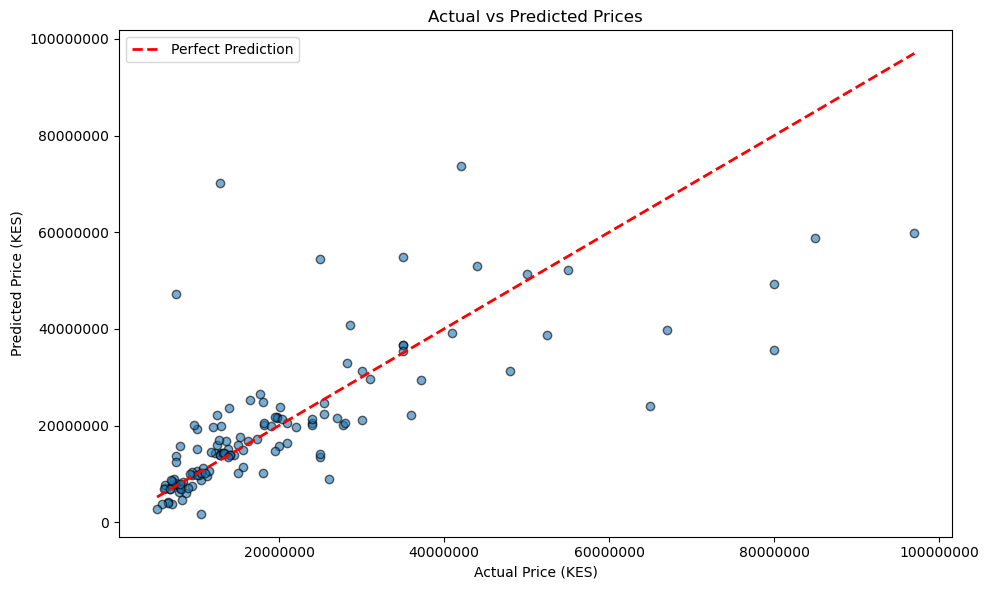

In [50]:
# Plot 1: Actual vs Predicted

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Price (KES)')
plt.ylabel('Predicted Price (KES)')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.ticklabel_format(style='plain', axis='both')
plt.tight_layout()
plt.savefig("actual_predicted_prices.png")
plt.show()

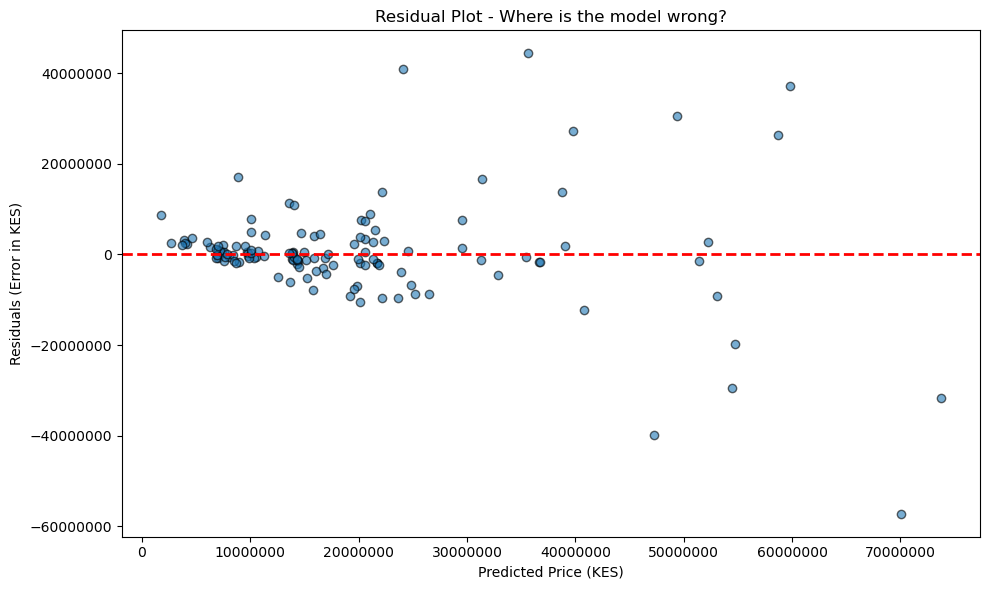

In [51]:
# Plot 2: Residuals (Prediction Errors)

residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6, edgecolors='black')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Price (KES)')
plt.ylabel('Residuals (Error in KES)')
plt.title('Residual Plot - Where is the model wrong?')
plt.ticklabel_format(style='plain', axis='both')
plt.tight_layout()
plt.savefig("residual plot.png")
plt.show()


Feature Impact on Price:
  property_type_encoded    :      12,064,627 KES
  amenity_score            :       4,956,012 KES
  bedrooms                 :       2,844,628 KES
  bathrooms                :       1,151,259 KES
  location_encoded         :         183,948 KES
  size_sqft                :           5,586 KES

  Base Price (Intercept)    :      -9,985,677 KES


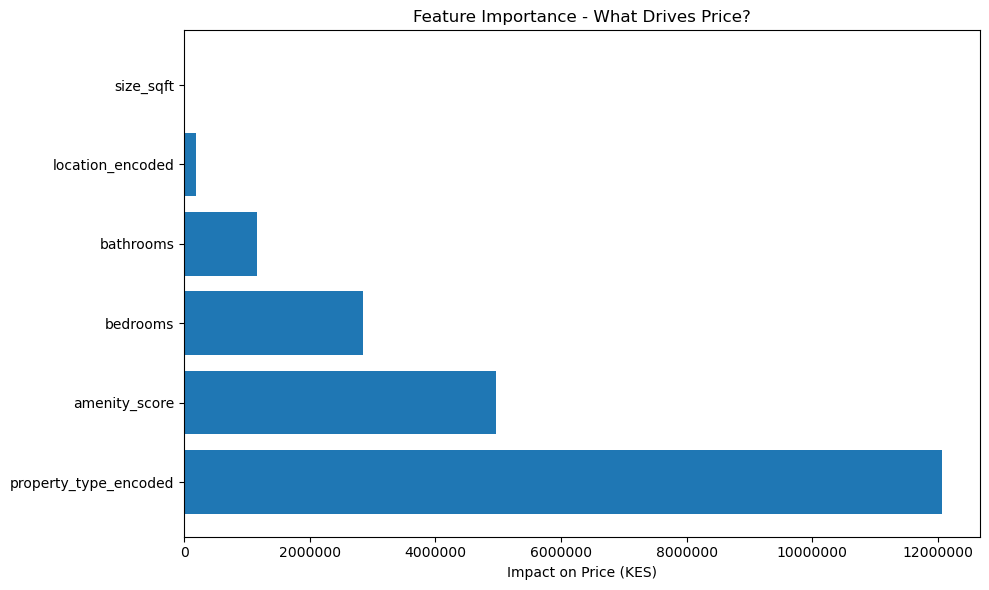

In [52]:
#Feature Importance - What drives price?

# Show feature weights
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Weight (KES)': model.coef_
}).sort_values('Weight (KES)', ascending=False)

print("\nFeature Impact on Price:")
for idx, row in feature_importance.iterrows():
    print(f"  {row['Feature']:25s}: {row['Weight (KES)']:>15,.0f} KES")

print(f"\n  Base Price (Intercept)    : {model.intercept_:>15,.0f} KES")

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Weight (KES)'])
plt.xlabel('Impact on Price (KES)')
plt.title('Feature Importance - What Drives Price?')
plt.ticklabel_format(style='plain', axis='x')
plt.tight_layout()
plt.savefig("feature importance.png")
plt.show()

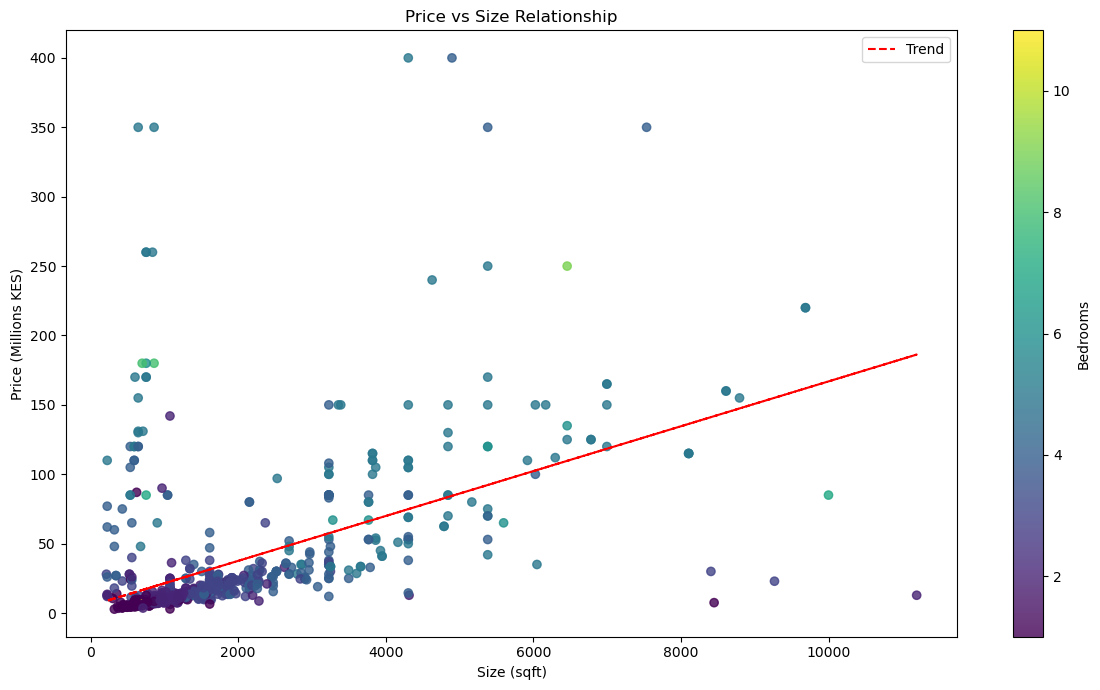

In [53]:
#PRICE VS SIZE SCATTER
plt.figure(figsize=(12, 7))

scatter = plt.scatter(
    df["size_sqft"],
    df["price_kes"] / 1e6,
    c=df["bedrooms"],
    cmap="viridis",
    alpha=0.8
)

# Trend line
z = np.polyfit(df["size_sqft"], df["price_kes"] / 1e6, 1)
p = np.poly1d(z)
plt.plot(df["size_sqft"], p(df["size_sqft"]), "r--", label="Trend")

plt.colorbar(scatter, label="Bedrooms")
plt.title("Price vs Size Relationship")
plt.xlabel("Size (sqft)")
plt.ylabel("Price (Millions KES)")
plt.legend()
plt.tight_layout()
plt.savefig("size_vs_price.png")
plt.show()

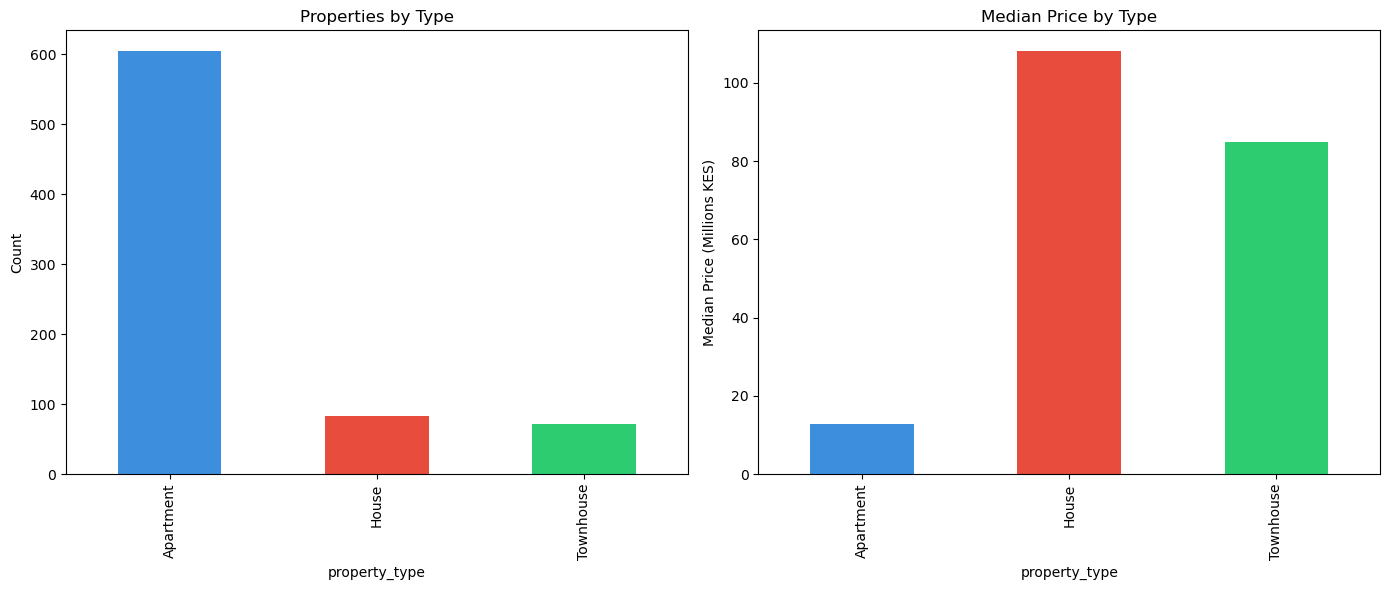

In [54]:
# PROPERTIES BY TYPE + MEDIAN PRICE
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Count
type_counts = df["property_type"].value_counts()
type_counts.plot(kind="bar", ax=ax[0], color=["#3E8EDE", "#E74C3C", "#2ECC71"])
ax[0].set_title("Properties by Type")
ax[0].set_ylabel("Count")

# Median price
median_price_type = df.groupby("property_type")["price_kes"].median() / 1e6
median_price_type.plot(kind="bar", ax=ax[1], color=["#3E8EDE", "#E74C3C", "#2ECC71"])
ax[1].set_title("Median Price by Type")
ax[1].set_ylabel("Median Price (Millions KES)")

plt.tight_layout()
plt.savefig("property_types.png")
plt.show()

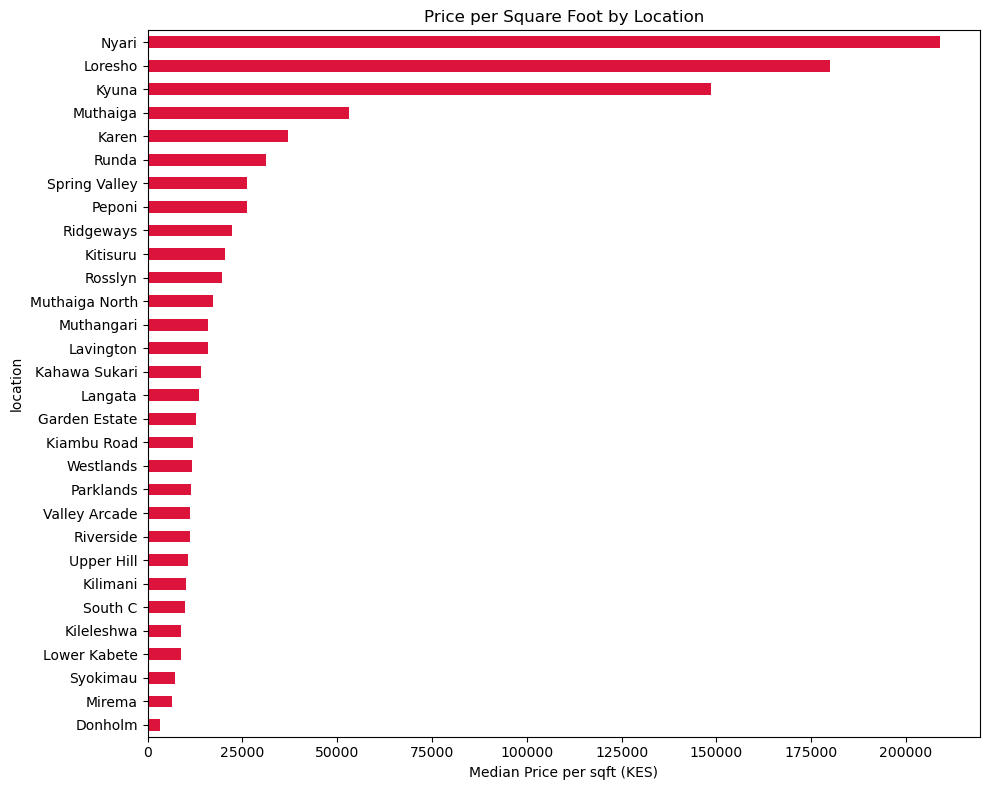

In [55]:
# ---------------------------------------------------
# PRICE PER SQFT BY LOCATION
# ---------------------------------------------------

median_sqft_location = (
    df.groupby("location")["price_per_sqft"]
    .median()
    .sort_values()
)

plt.figure(figsize=(10, 8))
median_sqft_location.plot(kind="barh", color="crimson")
plt.title("Price per Square Foot by Location")
plt.xlabel("Median Price per sqft (KES)")
plt.tight_layout()
plt.savefig("price_per_sqft_by_location.png")
plt.show()

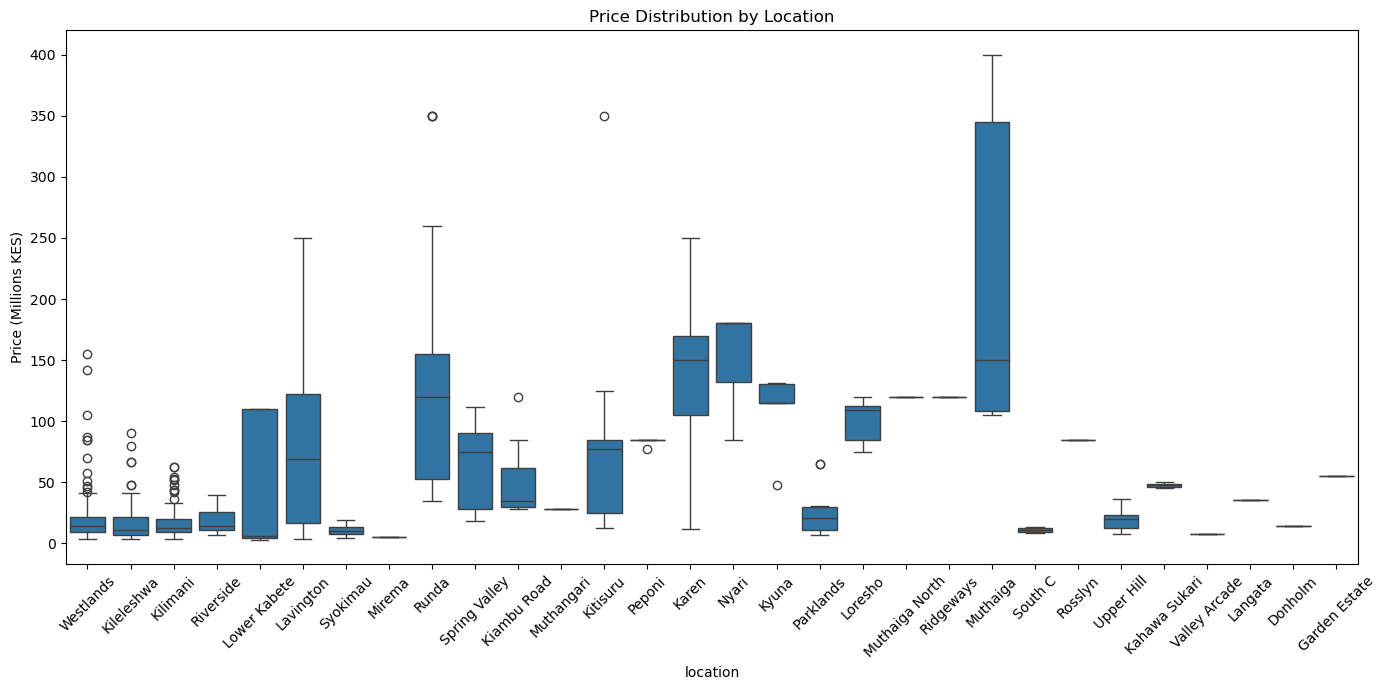

In [56]:
# PRICE DISTRIBUTION BY LOCATION (BOXPLOT)


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))

sns.boxplot(
    data=df,
    x="location",
    y=df["price_kes"] / 1e6
)

plt.xticks(rotation=45)
plt.title("Price Distribution by Location")
plt.ylabel("Price (Millions KES)")
plt.tight_layout()
plt.savefig("price_by_location.png")
plt.show()

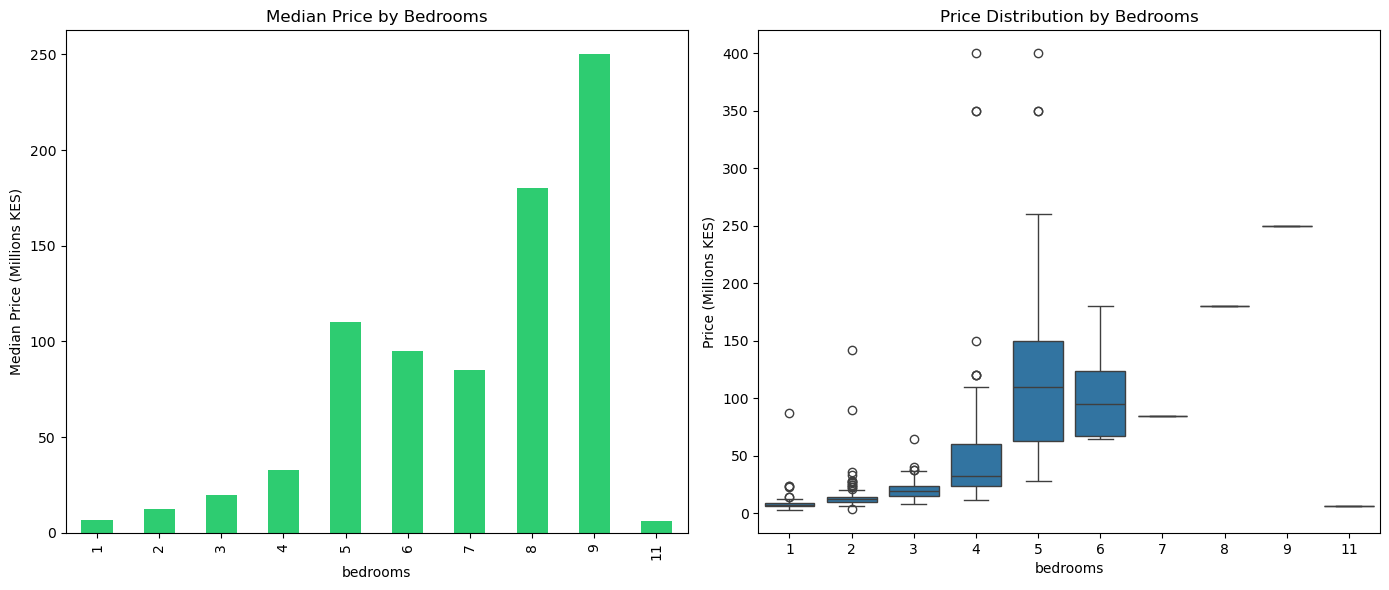

In [57]:
# 6. MEDIAN PRICE BY BEDROOMS + DISTRIBUTION


fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Median
median_bedrooms = df.groupby("bedrooms")["price_kes"].median() / 1e6
median_bedrooms.plot(kind="bar", ax=ax[0], color="#2ECC71")
ax[0].set_title("Median Price by Bedrooms")
ax[0].set_ylabel("Median Price (Millions KES)")

# Distribution
sns.boxplot(
    data=df,
    x="bedrooms",
    y=df["price_kes"] / 1e6,
    ax=ax[1]
)
ax[1].set_title("Price Distribution by Bedrooms")
ax[1].set_ylabel("Price (Millions KES)")

plt.tight_layout()
plt.savefig("price_by_bedrooms.png")
plt.show()

In [58]:
# Create market segments column

df["market_segment"] = pd.cut(
    df["price_kes"],
    bins=[0, 10_000_000, 30_000_000, 100_000_000],
    labels=[
        "Affordable (<10M)",
        "Mid-Range (10-30M)",
        "Premium (30-100M)"
    ]
)

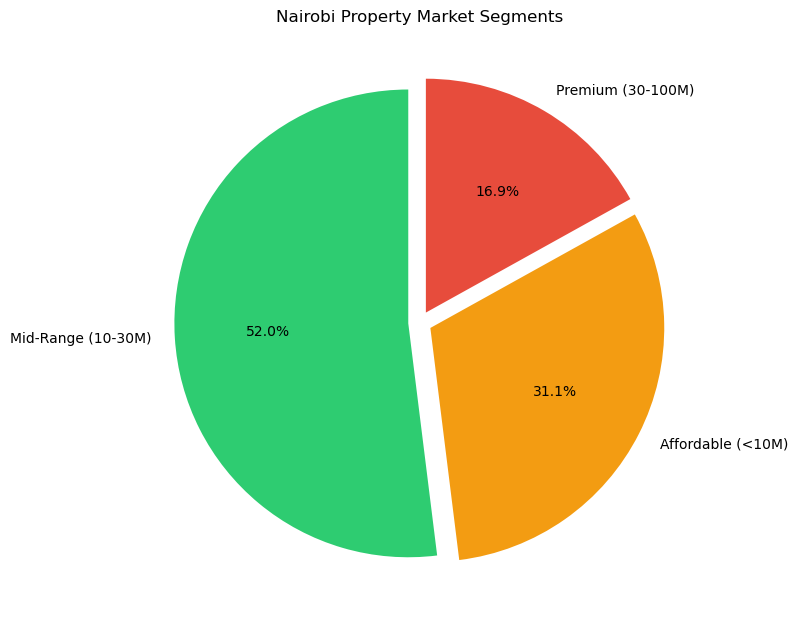

In [59]:
# 7. MARKET SEGMENTS PIE CHART

segment_counts = df["market_segment"].value_counts()

plt.figure(figsize=(8, 8))

plt.pie(
    segment_counts,
    labels=segment_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    explode=[0.05, 0.05, 0.05],
    colors=["#2ECC71", "#F39C12", "#E74C3C"]
)

plt.title("Nairobi Property Market Segments")
plt.tight_layout()
plt.savefig("nairobi_property_market_segments.png")
plt.show()

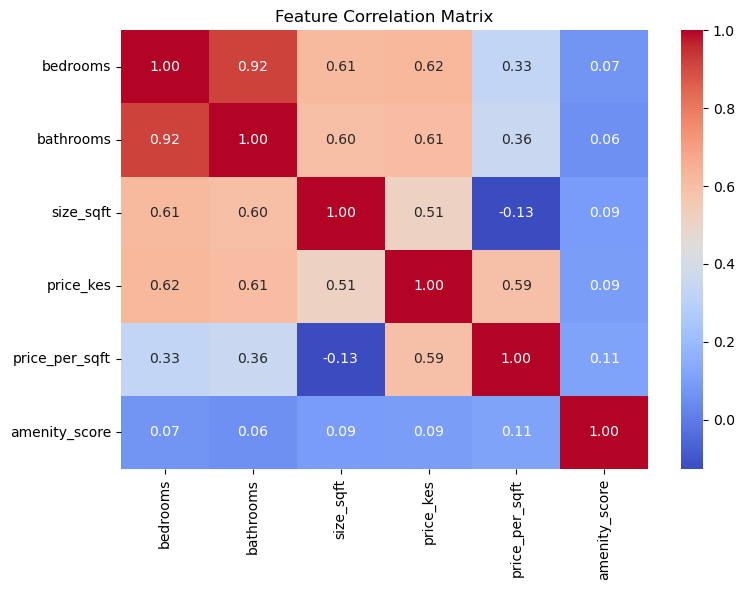

In [60]:
# 8. CORRELATION HEATMAP

plt.figure(figsize=(8, 6))

corr_cols = [
    "bedrooms",
    "bathrooms",
    "size_sqft",
    "price_kes",
    "price_per_sqft",
    "amenity_score"
]

corr = df[corr_cols].corr()

sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)

plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.savefig("correlation_heatmap.png")
plt.show()


In [61]:
# Summary

print(f" Model: Linear Regression")
print(f" Features: {len(feature_columns)}")
print(f" Training samples: {len(X_train)}")
print(f" Test samples: {len(X_test)}")

print(f"Performance:")
print(f"   MAE: ±{mae/1_000_000:.2f}M KES")
print(f"   R²: {r2:.3f} (explains {r2*100:.1f}% of price variance)")

print(f"Key Findings:")
print(f"   1. Property type is the strongest predictor")
print(f"   2. Each bedroom adds ~15M KES")
print(f"   3. Each sqft adds ~5K KES")
print(f"   4. Model works well for low-mid prices")
print(f"   5. Struggles with luxury properties (>100M)")

print(f"Next Steps")
print(f"   • Try Random Forest (handles non-linear patterns)")
print(f"   • Try XGBoost (better for complex relationships)")
print(f"   • Feature engineering improvements")

print("Model _Baseline Completed!")

 Model: Linear Regression
 Features: 6
 Training samples: 509
 Test samples: 128
Performance:
   MAE: ±6.22M KES
   R²: 0.524 (explains 52.4% of price variance)
Key Findings:
   1. Property type is the strongest predictor
   2. Each bedroom adds ~15M KES
   3. Each sqft adds ~5K KES
   4. Model works well for low-mid prices
   5. Struggles with luxury properties (>100M)
Next Steps
   • Try Random Forest (handles non-linear patterns)
   • Try XGBoost (better for complex relationships)
   • Feature engineering improvements
Model _Baseline Completed!
